In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.optimize import RootResults
import constants
from conversions import Kepler2Cartesian
from Kepler import KeplerSolver
import warnings
import ephaccess as ephem
import julian
import datetime
import matplotlib.pyplot as plt
import matplotlib
import tqdm
import importlib

In [2]:
def _Newton(func, x0, ftol, boundaries = None, maxit = 10000):
    x = x0 + 0.
    it = 0
    flag = -2
    desc = ''
    while True:
        it += 1
        if it >= maxit:
            break
        if boundaries:
            if not boundaries[0] <= x <= boundaries[1]:
                break
                flag = -3
        
        f, df = func(x)
        if abs(f) < ftol:
            flag = 0
            break

        x = x - f / df
    return RootResults(x, it, it, flag)
    
def _calc_moon(jd0, t, eph):
    # jd0 - julian date, t - seconds, f - opened ephem file
    jd = jd0 + t / 86400.
    jt_int = jd // 1
    jt_frac = jd % 1

    PV = eph.calculate_rectangular(eph.object_by_name("Moon"), eph.object_by_name("Earth"), jt_int, jt_frac)
    PV = np.array(PV)
    rL = PV[0] # units are set before (calc_fly_in)
    VL = PV[1]
    
    return rL, VL
    
def calc_fly_in(xref, jd, t1, t2, ftol, r_influence = 66194000, eph_file = "epm2017.bsp", maxit = 10000, explicit = True, already_boundary = False):
    """
    Input:
    xref - function, that takes time in seconds and returns phase(!) vector of the spacecraft
    jd - date of launch in the juliandate format
    t1 - left time boundary (in seconds counting from date 00:00:00)
    t2 - right time boundary (in seconds counting from date 00:00:00)\
    r_influecne - radius of sphere of influence in meters, 66 194 000 by default
    ephem_file - ephemeris file name, "epm2017.bsp" by default
    ftol - accuracy (r_influence - ftol < |r_rel| < r_influence + ftol)
    maxiter - number of iterations allowed to find in_time
    
    Time boundaries in xref must correspond date, t1 and t2
    
    Output:
    in_time - time at which the spacecraft flies into the region of influence, seconds
    r_rel - radius-vector of the spacecraft relative to the Moon at in_time, m
    V_rel - velocity of the spacecraft relative to the Moon at in_time, m/s
    rL - radius-vector of the Moon at in_time, m
    VL - velocity of the Moon at in_time, m/s
    None, None, None, None, None - if spacecraft doesn't fly into the region of influence at the time interval given 
    
    TODO:
    different reference systems
    """
    # |rref|(t) - r_influence = 0 may have more than 1 zero
    
    eph = ephem.EphAccess()
    eph.load_file(eph_file)
    eph.set_distance_units(ephem.EPH_KM)
    eph.set_time_units(ephem.EPH_SEC)
    
    if already_boundary:
        in_time = t2
        
        buf = xref(in_time)
        r = buf[:3]
        V = buf[3:]
        
        rL, VL = _calc_moon(jd, in_time, eph)
        
        r_rel = r - rL
        V_rel = V - VL
        
        return in_time, r_rel, V_rel, rL, VL
    
    def eq_2_solve(t):
        # first return is function value whose root we want to find
        # second return is it's derivative
        buf = xref(t)
        r = buf[:3]
        V = buf[3:]
        
        rL, VL = _calc_moon(jd, t, eph)
        
        buf = np.linalg.norm(r - rL)
        res1 = buf - r_influence
        res2 = np.dot(r - rL, V - VL) / buf
        return res1, res2        
    
    res = _Newton(eq_2_solve, x0 = t1, ftol = ftol, maxit = maxit, boundaries = (t1, t2))
    if explicit:
        print("Iterations done:", res.iterations)
    if res.converged:
        in_time = res.root
        
        buf = xref(in_time)
        r = buf[:3]
        V = buf[3:]
        
        rL, VL = _calc_moon(jd, in_time, eph)
        
        r_rel = r - rL
        V_rel = V - VL        
    else:
        warnings.warn("No root for in_time was found", RuntimeWarning)
        in_time = None
        r_rel = None
        V_rel = None
        rL = None
        VL = None
    
    del eph
    return in_time, r_rel, V_rel, rL, VL

In [3]:
def precession_matrix(jd):
    """
    This function calculates precession matrix for conversions between reference systems
    x_old(in ICRF(J2000)) = P @ x_new(in ICRF(jd))
    
    Input:
    jd - julian date
    
    Output:
    P - np.array 3x3 (float)
    """
    t = (jd - 2451545.0)/36525.0
    t2 = t**2
    t3 = t**3
    sec2rad = np.pi / 180 / 3600
    
    z = -(2306.2181 * t + 1.09468 * t2 + 0.018203 * t3) * sec2rad
    theta = (2004.3109 * t + 0.42665 * t2 - 0.041833 * t3) * sec2rad
    dzeta = -(2306.2181 * t + 0.30188 * t2 + 0.017998 * t3) * sec2rad
    
    M1 = np.array([[np.cos(z), -np.sin(z), 0], [np.sin(z), np.cos(z), 0], [0, 0, 1.]])
    M2 = np.array([[np.cos(theta), 0, np.sin(theta)], [0, 1., 0], [-np.sin(theta), 0, np.cos(theta)]])
    M3 = np.array([[np.cos(dzeta), -np.sin(dzeta), 0], [np.sin(dzeta), np.cos(dzeta), 0], [0, 0, 1.]])
    
    return M1 @ M2 @ M3

def f_name(jt_int, jt_frac, r, eph, target, mu, center = "Earth"):
    """
    r - radius vector of the sc relative to the Earth in KM
    """
    PV = eph.calculate_rectangular(eph.object_by_name(target), eph.object_by_name(center), jt_int, jt_frac)
    PV = np.array(PV)
    
    rN = PV[0, :] # km
    if target != center:
        res = mu * ((rN - r) / np.linalg.norm(rN - r)**3  - rN / np.linalg.norm(rN)**3) # km / s^2
    else:
        res = -mu * r / np.linalg.norm(r)**3
        
    return res

def f_2b(jd0, t, x, eph, name = "Earth", mu = constants.muEar, center = "Earth"):
    """
    t - time (in seconds) since jd0 (so the full julian date is jd0 + t / (24 * 60 * 60))
    """
    res = np.zeros((6))
    
    r = x[:3]
    
    jd = jd0 + t / 86400.
    jt_int = jd // 1
    jt_frac = jd % 1

    res[3:] += f_name(jt_int, jt_frac, r, eph, name, mu, center)
        
    res[:3] = x[3:]

    return res

def f_full(jd0, t, x, eph):
    """
    t - time (in seconds) since jd0 (so the full julian date is jd0 + t / (24 * 60 * 60))
    """
    names_mus = {"Sun": constants.muSun, "Mercury": constants.muMer, "Venus": constants.muVen,
                 "Earth": constants.muEar, "Moon": constants.muMoo, "Mars_BC": constants.muMar,
                 "Jupiter_BC": constants.muJup, "Saturn_BC": constants.muSat, "Uranus_BC": constants.muUra, 
                 "Neptune_BC": constants.muNep, "Pluto_BC": constants.muPlu} # km^3 / s^2
    res = np.zeros((6))
    
    r = x[:3]
    
    jd = jd0 + t / 86400.
    jt_int = jd // 1
    jt_frac = jd % 1

    for n, m in names_mus.items():
        res[3:] += f_name(jt_int, jt_frac, r, eph, n, m)
        
    res[:3] = x[3:]

    return res

def get_xref_from_x0(date, t1, t2, x0, dt_eval = 10, tolerance = 1e-10, eph_file = "epm2017.bsp"):
    """
    x0 in ECI(JD2000)
    """
    date = datetime.datetime(int(date[-4:]), int(date[3:5]), int(date[:2]))
    jd0 = julian.to_jd(date) # midnight!

    x0 = np.array(x0)

    N = int(np.ceil(np.abs(t2 - t1) // dt_eval))
    t_eval = np.linspace(t1, t2, N)
    
    eph = ephem.EphAccess()
    eph.load_file(eph_file)
    eph.set_distance_units(ephem.EPH_KM)
    eph.set_time_units(ephem.EPH_SEC)
    
    res = solve_ivp(lambda t, x: f_full(jd0, t, x, eph), (t1, t2), x0, t_eval = t_eval, rtol = tolerance, atol = tolerance)
#     res = solve_ivp(lambda t, x: f_2b(jd0, t, x, eph, name = "Moon", mu = constants.muMoo, center= "Moon"), (t1, t2), x0, t_eval = t_eval, rtol = tolerance, atol = tolerance)
    if res.success:
        res = res.y
    else:
        warnings.warn(f"IntegrationError: {res.message}", RuntimeWarning)
    x_ref = interp1d(t_eval, res, kind = 'cubic') # spline interpolation
    return x_ref

def get_xref(date, t1, t2, i, W, w, e, p, v0 = 0, dt_eval = 10, tolerance = 1e-10, eph_file = "epm2017.bsp", um = 1e-3):
    date = datetime.datetime(int(date[-4:]), int(date[3:5]), int(date[:2]))
    jd0 = julian.to_jd(date) # midnight!

    x0 = Kepler2Cartesian(i, W, w, e, p, v0) * um # um - meters in units; v = 0 -> r(0) = rp; in ECI(date)!!
    P = precession_matrix(jd0)
#     x0[:3] = P @ x0[:3] # now it's in ECI(J2000)
#     x0[3:] = P @ x0[3:] # now it's in ECI(J2000)
    # CHECK P.T!!!! The variant in diploma is below
    x0[:3] = P.T @ x0[:3] # now it's in ECI(J2000)
    x0[3:] = P.T @ x0[3:] # now it's in ECI(J2000)

    N = int(np.ceil(np.abs(t2 - t1) // dt_eval))
    t_eval = np.linspace(t1, t2, N)

    eph = ephem.EphAccess()
    eph.load_file(eph_file)
    eph.set_distance_units(ephem.EPH_KM)
    eph.set_time_units(ephem.EPH_SEC)
    
    res = solve_ivp(lambda t, x: f_full(jd0, t, x, eph), (t1, t2), x0, t_eval = t_eval, rtol = tolerance, atol = tolerance)
#     res = solve_ivp(lambda t, x: f_2b(jd0, t, x, eph, name = "Moon", mu = constants.muMoo, center= "Moon"), (t1, t2), x0, t_eval = t_eval, rtol = tolerance, atol = tolerance)
    if res.success:
        res = res.y
    else:
        warnings.warn(f"IntegrationError: {res.message}", RuntimeWarning)
    x_ref = interp1d(t_eval, res, kind = 'cubic') # spline interpolation
    return x_ref

## One trajectory in full model

In [4]:
r_influence = 66194

# Orbit parameters:
inc = 51.8 / 180 * np.pi
W = 18.1475 / 180 * np.pi
w = 0.3893 / 180 * np.pi

hp = 200e3
rp = constants.RE + hp # before impulse
Vp0 = np.sqrt(constants.muE / rp)
pump = 3130
Vp1 = Vp0 + pump # after impulse
a = 1 / (2 / rp - Vp1**2 / constants.muE)
e = 1 - rp / a
p = a * (1 - e**2)

date = '01.10.2021'
integration_time = 200 * 60 * 60
t1 = 12 * 60 * 60 # noon
t2 = t1 + integration_time
t_sep = 20 * 60
jd0 = julian.to_jd(datetime.datetime(int(date[-4:]), int(date[3:5]), int(date[:2]))) # midnight!

In [5]:
x_ref = get_xref(date, t1, t2, inc, W, w, e, p, dt_eval = 50, tolerance = 1e-10)

in_time, r_rel, V_rel, rL, VL = calc_fly_in(x_ref, jd0, t1, t2, ftol = 200, maxit = 15000, r_influence = r_influence) # the fly-in time found!
print(f"Time to reash Lunar sphere of influence: {(in_time-t1)/3600:0.3f} hours")

Iterations done: 5
Time to reash Lunar sphere of influence: 107.512 hours


## Ansamble of trajectories

### Errors

In [6]:
N_err = 1000
#N_err = 100

elements_mean = np.array([inc, W, w, e, p, a / 1e3])
elements_std = np.array([0.030 / 180 * np.pi, 0.2 / 180 * np.pi, 0.2 / 180 * np.pi, 0.00030, 0., 30.])
# it's more convinient to calculate p separately

seed = 42
np.random.seed(seed)

elements = np.random.normal(elements_mean, elements_std, (N_err, 6))
elements = elements.T
elements[4, :] = elements[5, :] * (1 - elements[3, :]**2) * 1e3 # p in meters

t2_corr = in_time + 5 * 60 * 60 # time2 corrected, not second correction!

trajectories_err = []
for j in tqdm.tqdm(range(N_err)):
    vi, Ei = KeplerSolver(a, e, t1 + t_sep, epoch = t1)
    trajectories_err.append(get_xref(date, t1 + t_sep, t2_corr, *elements[:5, j], v0 = vi, dt_eval = 50, tolerance = 1e-10))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


### Corrections

In [7]:
N_corr = 100
n = 10

t_corr_plot = t1 + 10 * 60 * 60
dV = 10e-3

x0_0 = x_ref(t_corr_plot)
ang1 = np.linspace(0, np.pi, n)
ang2 = np.linspace(0, 2 * np.pi, n)

# trajectories_corr = []
# for a1 in tqdm.tqdm(ang1):
#     for a2 in ang2:
#         x0 = x0_0 + np.array([0., 0., 0., dV * np.sin(a1) * np.cos(a2), dV * np.sin(a1) * np.sin(a2), dV * np.cos(a1)])
#         trajectories_corr.append(get_xref_from_x0(date, t_corr_plot, t2_corr, x0, dt_eval = 50, tolerance = 1e-10))

In [8]:
in_params_err = []
for j in range(N_err):
    in_params_err.append(calc_fly_in(trajectories_err[j], jd0, t1 + t_sep, t2_corr, ftol = 200, maxit = 15000, r_influence = r_influence, explicit = False))
in_params_err = np.array(in_params_err, dtype = object).T

# in_params_corr = []
# for j in range(N_corr):
#     in_params_corr.append(calc_fly_in(trajectories_corr[j], jd0, t_corr_plot, t2_corr, ftol = 5000, maxit = 15000, r_influence = r_influence, explicit = False))
# in_params_corr = np.array(in_params_corr, dtype = object).T

In [9]:
buf = np.zeros((6, N_err))
time_cov = t1 + 10 * 60 * 60
for i in range(N_err):
    buf[:, i] = trajectories_err[i](time_cov)
    
buf2 = np.cov(buf) # real covariance matrix

### Plot it!

In [10]:
import Bplane
importlib.reload(Bplane) # in-development need

def MoonOrientation(fi, theta, psi):
    """
    x_inECI = M @ x_inLunarPrincipalAxes
    
    Input:
    fi, theta, psi - Lunar libration angles in radians
    (see Folkner et al. - Planetary and Lunar Ephemerides DE430 and DE431, page 9)
    
    Returns:
    M - np.ndarray, shape (3, 3), float
    """
    M1 = np.array([[np.cos(fi), -np.sin(fi), 0], [np.sin(fi), np.cos(fi), 0], [0, 0, 1.]])
    M2 = np.array([[1., 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
    M3 = np.array([[np.cos(psi), -np.sin(psi), 0], [np.sin(psi), np.cos(psi), 0], [0, 0, 1.]])
    
    return M1 @ M2 @ M3


Bp = Bplane.Bplane(rL, VL, V_rel)
x_pp, y_pp = Bp.get_piercing_point(r_rel, V_rel)
B = np.sqrt(x_pp**2 + y_pp**2)

hp = Bp.get_rp(x_pp, y_pp, constants.muMoo, np.linalg.norm(V_rel), r_influence) - constants.RL / 1e3
print(f"Current periapsis height: {hp:0.0f} km")

d2r = np.pi / 180
M = MoonOrientation(-3.567318  * d2r, 22.822766  * d2r, 338.777833 * d2r)
wL = M @ np.array([0, 0, 1.])
wL = Bp.get_matrix().T @ wL

wL2plot = wL[:2]
wL2plot /= np.linalg.norm(wL2plot)

p0 = 1e2
V0 = 1e-3

TM = Bplane.TransitionMatrix(x_ref, t1, in_time, p0, V0, constants.muEar)

K1 = np.zeros((6, 6))
K1[0, 0] = (148)**2 # km^2
K1[1, 1] = (198)**2
K1[2, 2] = (270)**2

K1[3, 3] = (71e-3)**2 # (km/s)^2
K1[4, 4] = (86e-3)**2
K1[5, 5] = (96e-3)**2

# a_err1, b_err1, v_err1 = Bplane.ScatteringEllipse(K1, TM, Bp.get_matrix(),
#                                                   t1 + t_sep, in_time, p0, V0)

a_err1, b_err1, v_err1 = Bplane.ScatteringEllipse(buf2, TM, Bp.get_matrix(),
                                                  time_cov, in_time, p0, V0)
a_err1 *= p0
b_err1 *= p0


a_corr1, b_corr1, v_corr1 = Bplane.InfluenceEllipse(TM, Bp.get_matrix(), dV / V0, t_corr_plot, in_time)
a_corr1 *= p0
b_corr1 *= p0

Current periapsis height: 10000 km
Inv error K1: 8.230384475495661e-08
Inv error K2: 8.088450884411905e-09
Inv error A: 2.220446049250313e-16


In [11]:
%matplotlib widget
importlib.reload(Bplane) # in-development need

Bplot2 = Bplane.BplanePlotter(units_in = "km", units_out = "km")

Bplot2.set_size(x_pp, y_pp, 10000, 20000)

Bplot2.add_point(x_pp, y_pp, "piercing-point")

Bplot2.add_line(0, 0, *(wL2plot * B * 1.05), "Lunar pole", color = "green")

Bplot2.add_ellipse(x_pp, y_pp, a_err1, b_err1, v_err1 / np.pi * 180,
                   f"Err({(time_cov - t1) / 3600 :0.1f}h)", color = (1, 0, 0, 1))
# Bplot2.add_ellipse(x_pp, y_pp, a_corr1, b_corr1, v_corr1 / np.pi * 180,
#                    f"Corr({(t_corr_plot - t1)/ 3600 :0.1f}h, {dV*1e3 :0.1f}m/s)", color = (0, 0, 1, 1))

Bplot2.add_hp(hp , constants.RL / 1e3, constants.muMoo, np.linalg.norm(V_rel), r_influence, color = "purple")
Bplot2.add_hp(10000, constants.RL / 1e3, constants.muMoo, np.linalg.norm(V_rel), r_influence, color = "orange")

for i in range(N_err):
    x_ppi, y_ppi = Bp.get_piercing_point(in_params_err[1, i], in_params_err[2, i])
    Bplot2.add_point(x_ppi, y_ppi, f"pp_err{i}")
    
# for i in range(N_corr):
#     x_ppi, y_ppi = Bp.get_piercing_point(in_params_corr[1, i], in_params_corr[2, i])
#     Bplot2.add_point(x_ppi, y_ppi, f"pp_corr{i}")


Bplot2.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\glebp\OneDrive\Рабочий стол\Учеба\НИР\Code\Bplane.py:261: RuntimeWarning: The hp provided had already existed. It was recalculated.
  warnings.warn("The hp provided had already existed. It was recalculated.", RuntimeWarning)


## First correction
### Calculate the corrections

In [12]:
dt_1corr = 10 * 60 * 60
t_1corr = t1 + dt_1corr

first_corr = np.zeros((3, N_err))
for i in tqdm.tqdm(range(N_err)):
    # using TM instead of TM_buf is much faster yet in increases error in x_pp and y_pp up to 40km
    TM_buf = Bplane.TransitionMatrix(trajectories_err[i], t_1corr, t2_corr, p0, V0, constants.muEar)
    
    x_pp_buf, y_pp_buf = Bp.get_piercing_point(in_params_err[1, i], in_params_err[2, i])
    dxi = x_pp - x_pp_buf
    deta = y_pp - y_pp_buf

    first_corr[:, i] = Bplane.get_correction(TM_buf, Bp.get_matrix(), t_1corr, in_time, dxi, deta, p0, V0) # in_time (related to the x_ref)!!

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:03<00:00,  4.11it/s]


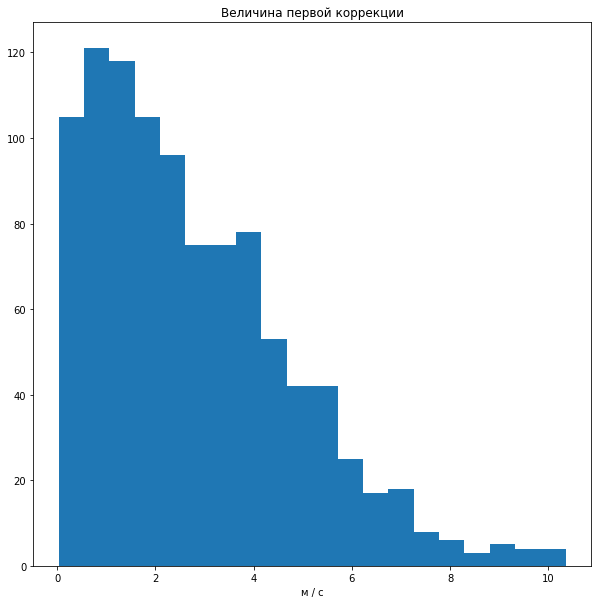

In [13]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(np.linalg.norm(first_corr, axis = 0) * 1e3, bins = 20)
plt.title("Величина первой коррекции")
plt.xlabel("м / с")
plt.show()

### Apply correction (with a static error)  
Every correction is assumed to has direction error +1 deg theta, -1 deg phi

In [14]:
def cart2spher(x, y, z):
    """
    x = r sin(theta) cos(phi)
    y = r sin(theta) sin(phi)
    z = r cos(theta)
    """  
    r = np.sqrt(x**2 + y**2 + z**2)
    
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    
    return [r, theta, phi]

def spher2cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return [x, y, z]

In [15]:
theta_err = 1 / 180 * np.pi
phi_err = -1 / 180 * np.pi
# theta_err = 0 / 180 * np.pi
# phi_err = -0 / 180 * np.pi
N_aft_1corr = N_err

trajectories_aft_1corr = []
for i in tqdm.tqdm(range(N_aft_1corr)):
    corr = first_corr[:, i]
    
    buf = cart2spher(*corr)
    buf[1] += theta_err
    buf[2] += phi_err
    corr = spher2cart(*buf)
    
    x0 = trajectories_err[i](t_1corr) + [0., 0., 0., *corr]
    trajectories_aft_1corr.append(get_xref_from_x0(date, t_1corr, t2_corr, x0, dt_eval = 50, tolerance = 1e-10))
    
in_params__aft_1corr = []
for j in range(N_aft_1corr):
    in_params__aft_1corr.append(calc_fly_in(trajectories_aft_1corr[j], jd0, t_1corr, t2_corr, ftol = 200, maxit = 15000, r_influence = r_influence, explicit = False))
in_params_aft_1corr = np.array(in_params__aft_1corr, dtype = object).T

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.26it/s]


### Plot

In [16]:
%matplotlib widget
import importlib
importlib.reload(Bplane) # in-development need

Bplot3 = Bplane.BplanePlotter(units_in = "km", units_out = "km")

Bplot3.set_size(x_pp, y_pp, 10000, 20000)

Bplot3.add_point(x_pp, y_pp, "piercing-point", color = "red")

Bplot3.add_line(0, 0, *(wL2plot * B * 1.05), "Lunar pole", color = "green")

Bplot3.add_hp(hp , constants.RL / 1e3, constants.muMoo, np.linalg.norm(V_rel), r_influence, color = "purple")
Bplot3.add_hp(10000, constants.RL / 1e3, constants.muMoo, np.linalg.norm(V_rel), r_influence, color = "orange")

for i in range(N_aft_1corr):
    x_ppi, y_ppi = Bp.get_piercing_point(in_params_aft_1corr[1, i], in_params_aft_1corr[2, i])
    Bplot3.add_point(x_ppi, y_ppi, f"pp_aft_1corr{i}")

Bplot3.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Second correction

### Calculate the corrections

In [17]:
dt_2corr = (in_time - t1) - 10 * 60 * 60
t_2corr = t1 + dt_2corr # time of the second correction, t2_corr is DIFFERENT

second_corr = np.zeros((3, N_aft_1corr))
for i in tqdm.tqdm(range(N_aft_1corr)):
    # using TM instead of TM_buf is much faster yet it increases error in x_pp and y_pp up to 40km
    TM_buf = Bplane.TransitionMatrix(trajectories_aft_1corr[i], t_2corr, t2_corr, p0, V0, constants.muEar)
    
    x_pp_buf, y_pp_buf = Bp.get_piercing_point(in_params_aft_1corr[1, i], in_params_aft_1corr[2, i])
    dxi = x_pp - x_pp_buf
    deta = y_pp - y_pp_buf

    second_corr[:, i] = Bplane.get_correction(TM_buf, Bp.get_matrix(), t_2corr, in_time, dxi, deta, p0, V0) # in_time because related to the x_ref!!

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.74it/s]


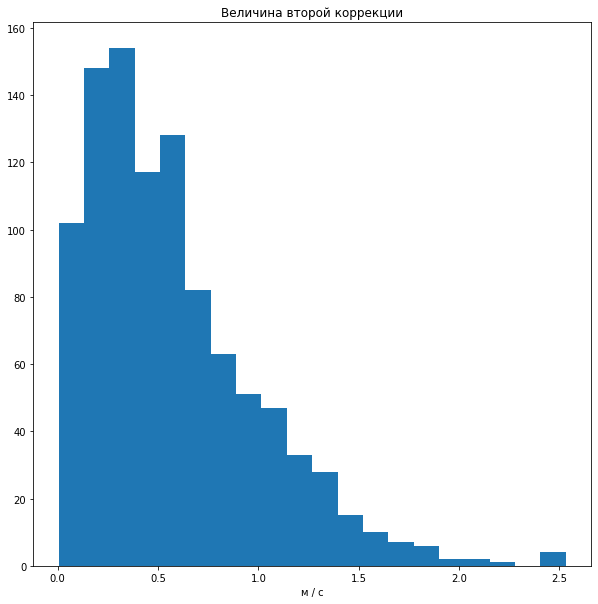

In [18]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(np.linalg.norm(second_corr, axis = 0) * 1e3, bins = 20)
plt.title("Величина второй коррекции")
plt.xlabel("м / с")
plt.show()

### Apply the corrections (with the static error)

In [19]:
N_aft_2corr = N_aft_1corr

trajectories_aft_2corr = []
for i in tqdm.tqdm(range(N_aft_2corr)):
    corr = second_corr[:, i]
    
    buf = cart2spher(*corr)
    buf[1] += theta_err
    buf[2] += phi_err
    corr = spher2cart(*buf)
    
    x0 = trajectories_aft_1corr[i](t_2corr) + [0., 0., 0., *corr]
    trajectories_aft_2corr.append(get_xref_from_x0(date, t_2corr, t2_corr, x0, dt_eval = 50, tolerance = 1e-10))
    
in_params_aft_2corr = []
for j in range(N_aft_2corr):
    in_params_aft_2corr.append(calc_fly_in(trajectories_aft_2corr[j], jd0, t_2corr, t2_corr, ftol = 200, maxit = 15000, r_influence = r_influence, explicit = False))
in_params_aft_2corr = np.array(in_params_aft_2corr, dtype = object).T

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.66it/s]


### Plot!

In [20]:
%matplotlib widget
import importlib
importlib.reload(Bplane) # in-development need

Bplot4 = Bplane.BplanePlotter(units_in = "km", units_out = "km")

Bplot4.set_size(x_pp, y_pp, 10000, 20000)

Bplot4.add_point(x_pp, y_pp, "piercing-point", color = "red")

Bplot4.add_line(0, 0, *(wL2plot * B * 1.05), "Lunar pole", color = "green")

Bplot4.add_hp(hp , constants.RL / 1e3, constants.muMoo, np.linalg.norm(V_rel), r_influence, color = "purple")
Bplot4.add_hp(10000, constants.RL / 1e3, constants.muMoo, np.linalg.norm(V_rel), r_influence, color = "orange")

B_buf = []
for i in range(N_aft_2corr):
    x_ppi, y_ppi = Bp.get_piercing_point(in_params_aft_2corr[1, i], in_params_aft_2corr[2, i])
    Bplot4.add_point(x_ppi, y_ppi, f"pp_aft_1corr{i}")
    B_buf.append(np.sqrt(x_ppi**2 + y_ppi**2))

Bplot4.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Third correction (Vinf)

### Calculation

In [21]:
t_3corr = in_time

third_corr = np.zeros((3, N_aft_2corr))
for i in tqdm.tqdm(range(N_aft_2corr)):
    # actually dV = Vinf_reference - Vinf_current
    third_corr[:, i] = Bplane.get_Vinf_correction(V_rel, in_params_aft_2corr[2, i])

100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333119.21it/s]


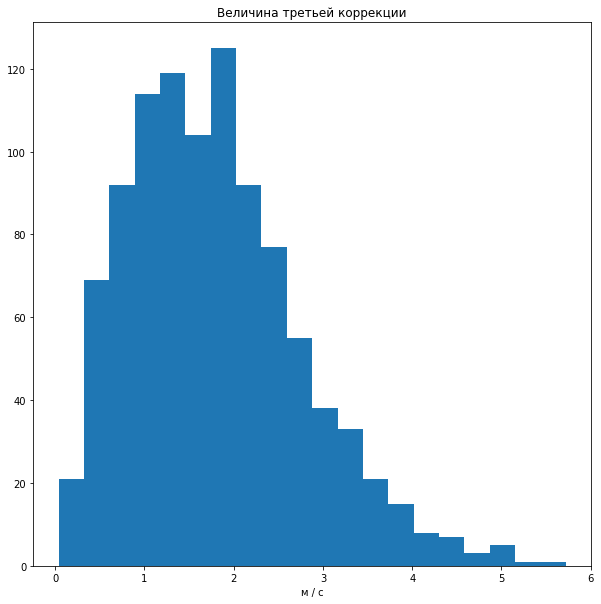

In [22]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(np.linalg.norm(third_corr, axis = 0) * 1e3, bins = 20)
plt.title("Величина третьей коррекции")
plt.xlabel("м / с")
plt.show()

### Apply the correction

In [23]:
N_aft_3corr = N_aft_2corr

trajectories_aft_3corr = []
for i in tqdm.tqdm(range(N_aft_3corr)):
    corr = third_corr[:, i]
    
    x0 = trajectories_aft_2corr[i](t_3corr) + [0., 0., 0., *corr]
    trajectories_aft_3corr.append(get_xref_from_x0(date, t_3corr, t2_corr, x0, dt_eval = 50, tolerance = 1e-10))
    
in_params_aft_3corr = []
for j in range(N_aft_3corr):
    in_params_aft_3corr.append(calc_fly_in(trajectories_aft_3corr[j], jd0, t_3corr, in_time, ftol = 500, maxit = 15000, r_influence = r_influence, explicit = False, already_boundary = True))
in_params_aft_3corr = np.array(in_params_aft_3corr, dtype = object).T

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.06it/s]


## Breaking impulses

In [24]:
final_trajs = trajectories_aft_3corr
in_params_final = in_params_aft_3corr
N_final = len(final_trajs)

In [25]:
hp_buf = []

for i in range(N_final):
    x_ppi, y_ppi = Bp.get_piercing_point(in_params_final[1, i], in_params_final[2, i])
    hp_buf.append(Bp.get_rp(x_ppi, y_ppi, constants.muMoo, np.linalg.norm(in_params_final[2, i]), r_influence) - constants.RL / 1e3)

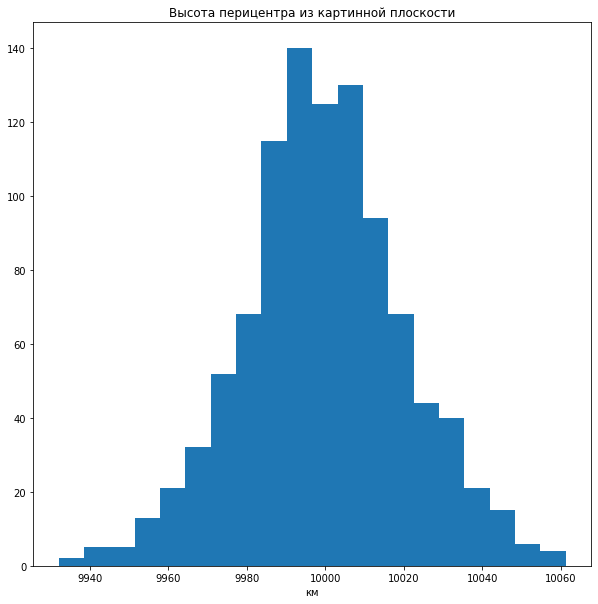

In [26]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(hp_buf, bins = 20)
plt.title("Высота перицентра из картинной плоскости")
plt.xlabel("км")
plt.show()

In [27]:
def calc_rp(r_inf, V_inf, mu):
    C = np.cross(r_inf, V_inf)
    c = np.linalg.norm(C)
    
    h = np.linalg.norm(V_inf)**2 - 2 * mu / np.linalg.norm(r_inf)
    
    e = np.sqrt(1 + h * c**2 / mu**2)
    p = c**2 / mu
    
    return p / (1 + e)

def calc_break_imp(r_inf, V_inf, rp, mu):
    Vp = np.sqrt(V_inf**2 + 2 * mu * (1./rp - 1./r_inf))
    Vcirc = np.sqrt(mu / rp)
    return Vcirc - Vp

In [28]:
mu = constants.muMoo
R_planet = constants.RL / 1e3

M = MoonOrientation(-3.567318  * d2r, 22.822766  * d2r, 338.777833 * d2r)
wL = M @ np.array([0, 0, 1.])
wL /= np.linalg.norm(wL)

angle_final = np.zeros(N_final)
final_hps = np.zeros(N_final)
break_imps = np.zeros(N_final)
for i in range(N_final):
    r_rel_buf = in_params_final[1, i]
    V_rel_buf = in_params_final[2, i]
    
    C_buf = np.cross(r_rel_buf, V_rel_buf)
    C_buf /= np.linalg.norm(C_buf)
    
    angle_final[i] = np.arccos(np.dot(C_buf, wL)) / np.pi * 180
    
    r_inf = np.linalg.norm(r_rel_buf)
    V_inf = np.linalg.norm(V_rel_buf)
    
    rp_buf = calc_rp(r_rel_buf, V_rel_buf, mu)
    final_hps[i] = rp_buf - R_planet
    
    break_imps[i] = calc_break_imp(r_inf, V_inf, rp_buf, mu)

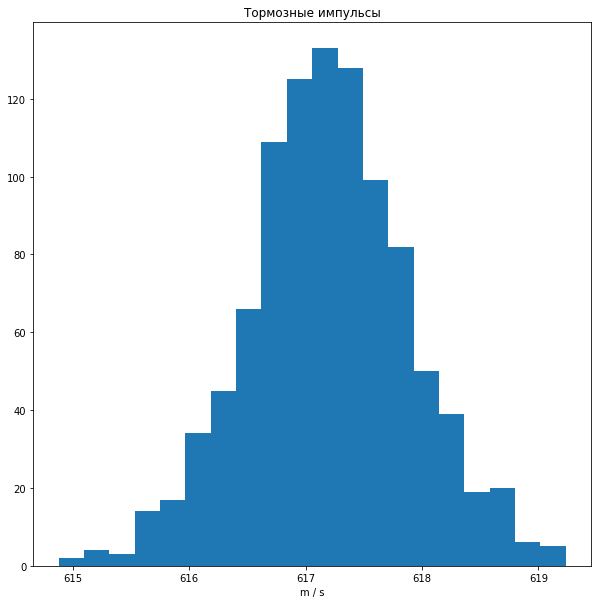

In [29]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(np.abs(break_imps) * 1e3, bins = 20)
plt.title("Тормозные импульсы")
plt.xlabel("m / s")
plt.show()

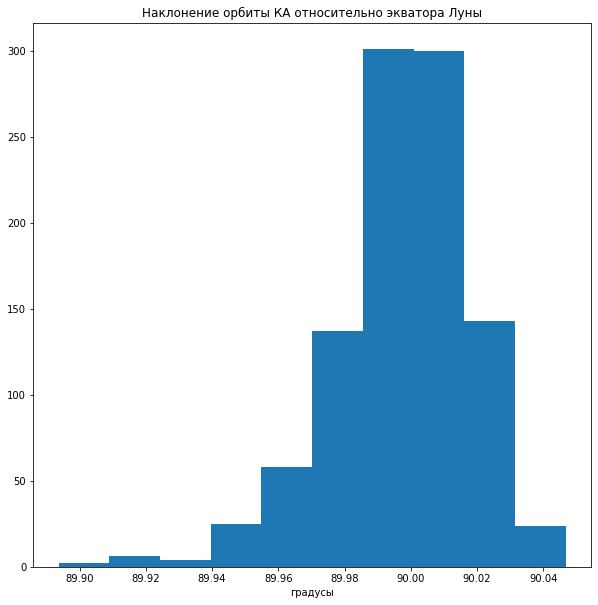

In [30]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(angle_final)
plt.title("Наклонение орбиты КА относительно экватора Луны")
plt.xlabel("градусы")
plt.show()

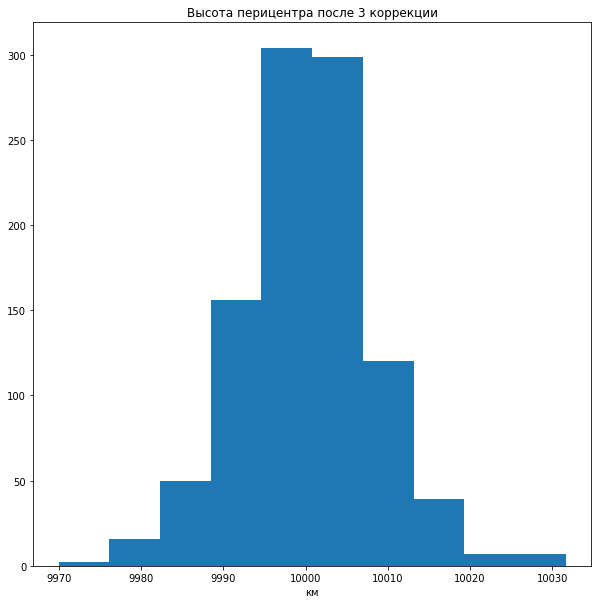

In [31]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(final_hps)
# plt.title("Итоговая высота перицентра")
plt.title("Высота перицентра после 3 коррекции")
plt.xlabel("км")
plt.show()

In [32]:
mu = constants.muMoo
R_planet = constants.RL / 1e3

final_hps_aft_2corr = np.zeros(N_aft_1corr)
break_imps_aft_2corr = np.zeros(N_aft_1corr)
for i in range(N_aft_2corr):
    r_rel_buf = in_params_aft_2corr[1, i]
    V_rel_buf = in_params_aft_2corr[2, i]
    
    r_inf = np.linalg.norm(r_rel_buf)
    V_inf = np.linalg.norm(V_rel_buf)
    
    rp_buf = calc_rp(r_rel_buf, V_rel_buf, mu)
    final_hps_aft_2corr[i] = rp_buf - R_planet
    
    break_imps_aft_2corr[i] = calc_break_imp(r_inf, V_inf, rp_buf, mu)

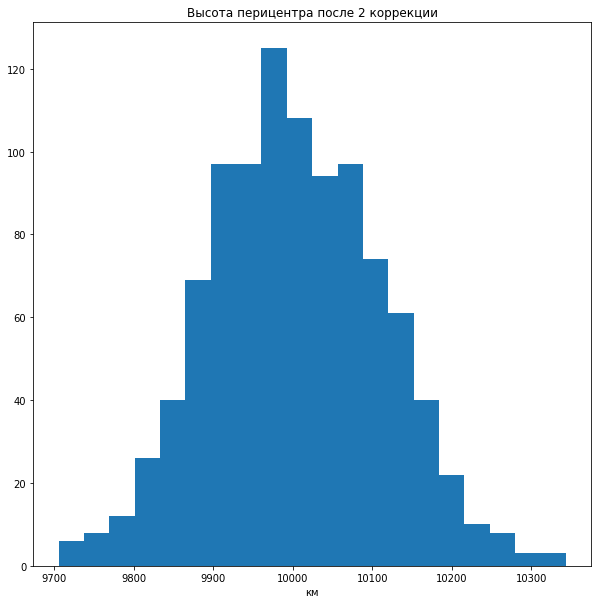

In [33]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(final_hps_aft_2corr, bins = 20)
plt.title("Высота перицентра после 2 коррекции")
plt.xlabel("км")
plt.show()

In [34]:
mu = constants.muMoo
R_planet = constants.RL / 1e3

final_hps_aft_1corr = np.zeros(N_aft_1corr)
break_imps_aft_1corr = np.zeros(N_aft_1corr)
for i in range(N_aft_1corr):
    r_rel_buf = in_params_aft_1corr[1, i]
    V_rel_buf = in_params_aft_1corr[2, i]
    
    r_inf = np.linalg.norm(r_rel_buf)
    V_inf = np.linalg.norm(V_rel_buf)
    
    rp_buf = calc_rp(r_rel_buf, V_rel_buf, mu)
    final_hps_aft_1corr[i] = rp_buf - R_planet
    
    break_imps_aft_1corr[i] = calc_break_imp(r_inf, V_inf, rp_buf, mu)

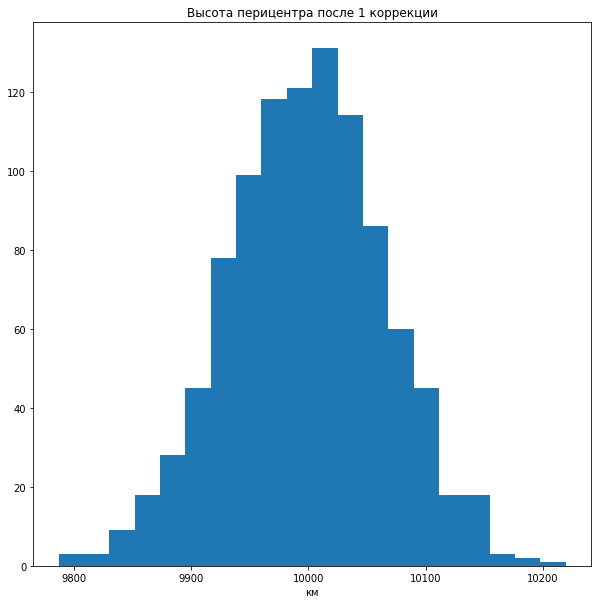

In [35]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(final_hps_aft_1corr, bins = 20)
plt.title("Высота перицентра после 1 коррекции")
plt.xlabel("км")
plt.show()

In [36]:
mu = constants.muMoo
R_planet = constants.RL / 1e3

final_hps_err = np.zeros(N_err)
break_imps_err = np.zeros(N_err)
for i in range(N_err):
    r_rel_buf = in_params_err[1, i]
    V_rel_buf = in_params_err[2, i]
    
    r_inf = np.linalg.norm(r_rel_buf)
    V_inf = np.linalg.norm(V_rel_buf)
    
    rp_buf = calc_rp(r_rel_buf, V_rel_buf, mu)
    final_hps_err[i] = rp_buf - R_planet
    
    break_imps_err[i] = calc_break_imp(r_inf, V_inf, rp_buf, mu)

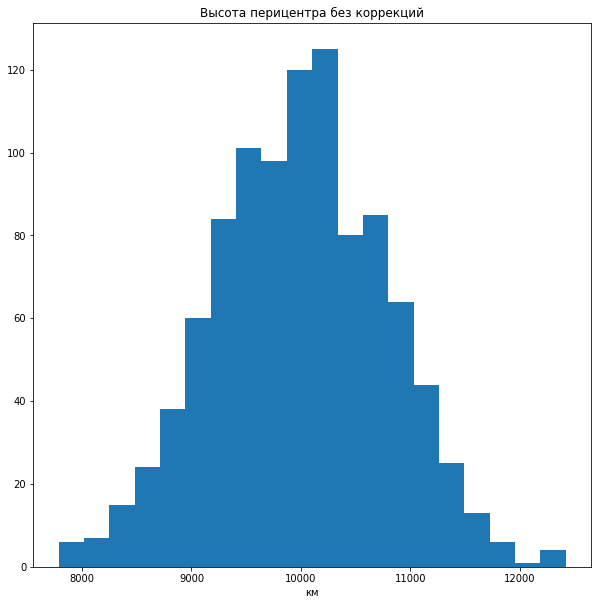

In [37]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(final_hps_err, bins = 20)
plt.title("Высота перицентра без коррекций")
plt.xlabel("км")
plt.show()

In [38]:
# Testing

# ind = np.argmax([np.linalg.norm(in_params_aft_3corr[2, i] - V_rel) for i in range(N_aft_2corr)])

# B = np.sqrt(x_pp**2 + y_pp**2)
# rp = 10010 + constants.RL / 1e3
# mu = constants.muMoo
# ri_ref = np.linalg.norm(r_rel)
# Vi_ref = np.linalg.norm(V_rel)
# b = 2 * mu / Vi_ref**2

# ri = np.linalg.norm(in_params_aft_3corr[1, ind])
# Vi = np.linalg.norm(in_params_aft_3corr[2, ind])
# x_ppi, y_ppi = Bp.get_piercing_point(in_params_aft_3corr[1, ind], in_params_aft_3corr[2, ind])
# Bi = np.sqrt(x_ppi**2 + y_ppi**2)
# bi = 2 * mu / Vi**2

# np.dot(in_params_aft_3corr[2, ind], V_rel) / (Vi * Vi_ref)